In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import category_encoders as ce
import math
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import recall_score, classification_report, precision_score
from sklearn.decomposition import TruncatedSVD
from imblearn.over_sampling import RandomOverSampler
from boruta import BorutaPy
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder

In [2]:
train = pd.read_csv('train_dataset_train.csv')
test = pd.read_csv('test_dataset_test.csv')

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
train

,id,age_indicator,month_id,student_id,program_id,carts_created_at,spent_time_total,spent_time_to_complete_hw,completed_hw,failed_hw,reworked_hw,interacted_hw,avg_hw_mark,test_with_good_mark,test_with_great_mark,webinars,avg_quiz_result,notes,hw_leader,lessons,activity,bought_d1,bought_d2,bought_d3,bought_d4,bought_d5,bought_avg_duration,payment_type,promo,price,communication_type,auto_payment,ABC,city,country,gender,speed_recall,os,browser,platform,m_avg_talk_duration,m_avg_duration,m_missed_calls,m_total_calls,m_was_conversations,m_total_duration,p_avg_talk_duration,p_avg_duration,p_missed_calls,p_total_calls,p_was_conversations,p_total_duration,support_feedback_avg,feedback_avg_d1,feedback_avg_d2,feedback_avg_d3,feedback_avg_d4,feedback_avg_d5,target
0,15182,32.0,9/30/2020,6694527,1469,8/26/2020,163.0,0.0,1.0,0.0,17.0,3.0,100.0,12.0,8.0,0.0,NaN,147.0,0.0,14.0,32.0,0,0,0,0,0,NaN,1,+,20042.959300,phone,0,D,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,NaN,NaN,0
1,89385,NaN,6/30/2021,6712877,1392,8/5/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,1,-,15057.315000,order,1,A,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,47931,NaN,2/28/2021,6659444,376,6/20/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,1,+,23389.029300,web,0,D,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,279085,1.0,11/30/2021,7151591,1160,4/14/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,1,-,22260.632220,order,1,B,NaN,NaN,1.0,NaN,Windows,Chrome,pc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,7806,30.0,10/31/2020,6705666,952,7/19/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,1,-,7255.515915,order,1,A,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,179932,27.0,11/30/2021,6816668,1043,10/16/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1,0,40.0,1,+,10263.967450,order,1,D,NaN,NaN,1.0,NaN,NaN,NaN,NaN,0.0,NaN,3.0,3.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,0
199996,257734,NaN,9/30/2021,6984939,1635,1/2/2021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,1,-,35998.565400,order,0,D,NaN,NaN,0.0,NaN,iOS,Mobile Safari,mobile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,0
199997,43549,17.0,3/31/2021,6670084,789,6/29/2020,NaN,NaN,0.0,0.0,0.0,2.0,NaN,0.0,0.0,0.0,NaN,0.0,0.0,2.0,0.0,0,0,0,0,0,NaN,1,+,22084.062000,web,0,D,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,4.0,NaN,0
199998,100800,NaN,6/30/2021,6917324,476,12/7/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,NaN,1,-,14377.805400,order,1,A,NaN,NaN,0.0,NaN,Android,Samsung Internet,mobile,6.0,6.0,0.0,1.0,1.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


# Предобработка данных

In [5]:
# вспомогательный флаг тренировочного и тестовой частей общего набора данных
train['train'] = 1
test['train'] = 0
# объединение в один датасет
train = pd.concat([train, test]).reset_index(drop=True)

In [6]:
# некоторые колонки с количественными переменными следует заполнить нулями,
# а некоторые заполнить "типичным" значением
cols_to_fill_with_zero = ['avg_quiz_result', 'bought_avg_duration', 'speed_recall', 'm_avg_talk_duration', 'm_avg_duration', \
                          'm_missed_calls', 'm_total_calls', 'm_was_conversations', 'm_total_duration', 'p_avg_talk_duration', \
                          'p_avg_duration', 'p_missed_calls', 'p_total_calls', 'p_was_conversations', 'p_total_duration', \
                          'support_feedback_avg', 'feedback_avg_d1', 'feedback_avg_d2', 'feedback_avg_d3', 'feedback_avg_d4', \
                          'feedback_avg_d5', 'avg_hw_mark']
cols_to_fill_with_avg = ['age_indicator', 'spent_time_total', 'spent_time_to_complete_hw', 'completed_hw', \
                         'failed_hw', 'reworked_hw', 'interacted_hw', 'test_with_good_mark', \
                         'test_with_great_mark', 'webinars', 'notes', 'hw_leader', \
                         'lessons', 'activity', 'bought_d1', 'bought_d2', 'bought_d3', 'bought_d4', \
                         'bought_d5', 'price', 'gender']

cols_to_fill_with_nan = ['communication_type', 'city', 'country', 'os', 'browser', 'platform']

for i in cols_to_fill_with_zero:
    train.fillna({i: 0}, inplace=True)

for i in cols_to_fill_with_avg:
    train.fillna({i: train[i].median()}, inplace=True)

for i in cols_to_fill_with_nan:
    train.fillna({i: 'None'}, inplace=True)

In [7]:
# переведём колонку в формат datetime и возьмём из неё только месяц
train['month_id'] = pd.to_datetime(train['month_id'], format = "%m/%d/%Y")
train['day_id'] = pd.DatetimeIndex(train['month_id']).day
train['day_of_week_id'] = pd.DatetimeIndex(train['month_id']).day_of_week
train['month_id'] = pd.DatetimeIndex(train['month_id']).month

In [8]:
# переведём колонку в формат datetime
train['carts_created_at'] = pd.to_datetime(train['carts_created_at'], format = "%m/%d/%Y")
train['carts_created_at_month'] = pd.DatetimeIndex(train['carts_created_at']).month
train['carts_created_at_day'] = pd.DatetimeIndex(train['carts_created_at']).day
train['carts_created_at_day_of_week'] = pd.DatetimeIndex(train['carts_created_at']).day_of_week
train = train.drop(['carts_created_at'],1)

C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/2451815549.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train = train.drop(['carts_created_at'],1)


In [9]:
# удалим переменные не содержащие информации
train = train.drop(['spent_time_to_complete_hw'], 1)

C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/44424804.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train = train.drop(['spent_time_to_complete_hw'], 1)


In [10]:
# в нужный формат
def promo(x):
    if x == '+':
        return 1
    else:
        return 0
train['promo'] = train['promo'].map(lambda x: promo(x))

In [11]:
# разделим выборки
XY_train = train[train['train'] == 1].drop('train', axis=1)
XY_test = train[train['train'] == 0].drop('train', axis=1)
XY_train, XY_val = train_test_split(XY_train, test_size=0.2, random_state=23)

X_train = XY_train.drop(['target'], 1)
Y_train = XY_train['target']

X_val = XY_val.drop(['target'], 1)
Y_val = XY_val['target']

X_test = XY_test.drop(['target'], 1)

C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/1474686982.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = XY_train.drop(['target'], 1)
C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/1474686982.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_val = XY_val.drop(['target'], 1)
C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/1474686982.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = XY_test.drop(['target'], 1)


In [12]:
categorial_vars = ['program_id', 'student_id', 'communication_type', 'ABC', 'city', 'country', 'os', 'browser', \
                   'platform']

In [13]:
class OneHotTargetEncoder():
    def __init__(self, class_names = None, target_encoders = {}):
        self.target_encoders = target_encoders
        self.class_names = class_names
    def fit(self, X, y):
        y=y.astype(str)
        enc = OneHotEncoder(handle_unknown='ignore')
        y_onehot = pd.DataFrame(enc.fit_transform(pd.DataFrame(Y_train)).toarray())
        self.class_names=y_onehot.columns
        for class_ in self.class_names:
            enc=ce.CatBoostEncoder()
            enc.fit(X,y_onehot[class_]) #convert all categorical
            self.target_encoders[class_] = enc
    def transform(self, X):
        X_obj=X
        for class_ in self.class_names:
            X_temp = self.target_encoders[class_].transform(X_obj)
            X_temp.columns = [str(i)+'_'+str(class_) for i in X_temp.columns]
            X = pd.concat([X,X_temp],axis=1)
        return X.drop(X_obj.columns,1)

In [14]:
one_hot_target_encoder = OneHotTargetEncoder()

one_hot_target_encoder.fit(X_train[categorial_vars], Y_train)

X_train = pd.concat([X_train, one_hot_target_encoder.transform(X_train[categorial_vars])], axis=1)
X_val = pd.concat([X_val, one_hot_target_encoder.transform(X_val[categorial_vars])], axis=1)
X_test = pd.concat([X_test, one_hot_target_encoder.transform(X_test[categorial_vars])], axis=1)

X_train = X_train.drop(categorial_vars,1)
X_val = X_val.drop(categorial_vars,1)
X_test = X_test.drop(categorial_vars,1)

C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/218761128.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  return X.drop(X_obj.columns,1)
C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/2393891689.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = X_train.drop(categorial_vars,1)
C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/2393891689.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_val = X_val.drop(categorial_vars,1)
C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/2393891689.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = X_test.drop(categorial_vars,1)


In [15]:
# Источник: stackoverflow
# Feature selection class to eliminate multicollinearity
# Выбор и удаление признаков скоррелированных между собой (борьба с мультиколлинеарносстью)
class MultiCollinearityEliminator():

    # Class initialisation
    # Инициализация класса
    def __init__(self, df, target, threshold=0.5):
        self.df = df
        self.target = target
        self.threshold = threshold

    # Method to create and return the feature correlation matrix dataframe
    # Метод создающий и возращающий корреляционную матрицу признаков датафрейма
    def createCorrMatrix(self, include_target=False):
        # Checking we should include the target in the correlation matrix
        if (include_target == False):
            #df_temp = self.df.drop([self.target], axis=1)
            df_temp = self.df

            # Setting method to Pearson to prevent issues in case the default method for df.corr() gets changed
            # Setting min_period to 30 for the sample size to be statistically significant (normal) according to
            # central limit theorem
            corrMatrix = df_temp.corr(method='pearson', min_periods=30).abs()

        # Target is included for creating the series of feature to target correlation - Please refer the notes under the
        # print statement to understand why we create the series of feature to target correlation
        elif (include_target == True):
            corrMatrix = self.df.corr(method='pearson', min_periods=30).abs()

        return corrMatrix

    # Method to create and return the feature to target correlation matrix dataframe
    # Метод создающий и возвращающий корреляционную матрицу признаков с целевой переменной
    def createCorrMatrixWithTarget(self):

        # After obtaining the list of correlated features, this method will help to view which variables
        # (in the list of correlated features) are least correlated with the target
        # This way, out the list of correlated features, we can ensure to elimate the feature that is
        # least correlated with the target
        # This not only helps to sustain the predictive power of the model but also helps in reducing model complexity

        # Obtaining the correlation matrix of the dataframe (along with the target)
        corrMatrix = self.createCorrMatrix(include_target=True)

        # Creating the required dataframe, then dropping the target row
        # and sorting by the value of correlation with target (in asceding order)
        corrWithTarget = pd.DataFrame(corrMatrix.loc[:, self.target]).drop(
            [self.target], axis=0).sort_values(by=self.target)
        #print(corrWithTarget, '\n')
        return corrWithTarget

    # Method to create and return the list of correlated features
    # Метод создающий и вовзращающий лист скоррелированных признаков
    def createCorrelatedFeaturesList(self):
        # Obtaining the correlation matrix of the dataframe (without the target)
        corrMatrix = self.createCorrMatrix(include_target=False)
        colCorr = []
        # Iterating through the columns of the correlation matrix dataframe
        for column in corrMatrix.columns:
            # Iterating through the values (row wise) of the correlation matrix dataframe
            for idx, row in corrMatrix.iterrows():
                if(row[column] > self.threshold) and (row[column] < 1):
                    # Adding the features that are not already in the list of correlated features
                    if (idx not in colCorr):
                        colCorr.append(idx)
                    if (column not in colCorr):
                        colCorr.append(column)
        #print(colCorr, '\n')
        return colCorr

    # Method to eliminate the least important features from the list of correlated features
    # Метод удаляющий наименее важные признаки (наименее скоррелированные с целевым признаком) из двух скоррелированных признаков
    def deleteFeatures(self, colCorr):
        # Obtaining the feature to target correlation matrix dataframe
        corrWithTarget = self.createCorrMatrixWithTarget()
        for idx, row in corrWithTarget.iterrows():
            #print(idx, '\n')
            if (idx in colCorr):
                self.df = self.df.drop(idx, axis=1)
                break
        return self.df

    # Method to run automatically eliminate multicollinearity
    # Метод запускающий и удаляющий мультиколлинеарность
    def autoEliminateMulticollinearity(self):
        # Obtaining the list of correlated features
        colCorr = self.createCorrelatedFeaturesList()
        while colCorr != []:
            # Obtaining the dataframe after deleting the feature (from the list of correlated features)
            # that is least correlated with the taregt
            self.df = self.deleteFeatures(colCorr)
            # Obtaining the list of correlated features
            colCorr = self.createCorrelatedFeaturesList()
        return self.df

In [16]:
# устраним скоррелированные признаки
corr_explorer = MultiCollinearityEliminator(pd.concat([X_train, Y_train], axis=1), 'target', 0.75)

X_train = corr_explorer.autoEliminateMulticollinearity().drop(['target'],1)

X_val = X_val.drop(X_val.columns.difference(X_train.columns),1)
X_test = X_test.drop(X_test.columns.difference(X_train.columns),1)

C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/3721317429.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = corr_explorer.autoEliminateMulticollinearity().drop(['target'],1)
C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/3721317429.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_val = X_val.drop(X_val.columns.difference(X_train.columns),1)
C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/3721317429.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = X_test.drop(X_test.columns.difference(X_train.columns),1)


In [17]:
X_train

,id,age_indicator,month_id,spent_time_total,failed_hw,reworked_hw,avg_hw_mark,test_with_good_mark,webinars,avg_quiz_result,notes,hw_leader,activity,bought_d1,bought_d2,bought_d3,bought_d4,bought_d5,bought_avg_duration,payment_type,promo,price,auto_payment,gender,speed_recall,m_avg_duration,m_total_calls,p_total_calls,p_was_conversations,p_total_duration,support_feedback_avg,feedback_avg_d1,feedback_avg_d2,feedback_avg_d3,feedback_avg_d4,feedback_avg_d5,day_id,day_of_week_id,carts_created_at_month,carts_created_at_day,carts_created_at_day_of_week,program_id_0,student_id_0,ABC_0,city_0,country_0,program_id_1,student_id_1,ABC_1,city_1,program_id_2,student_id_2,communication_type_2,city_2,country_2,os_2,browser_2,program_id_3,student_id_3,communication_type_3,city_3,country_3,program_id_4,student_id_4,city_4,country_4,browser_4,program_id_5,student_id_5,ABC_5,city_5,country_5,os_5,browser_5,platform_5
83245,151631,20.0,9,38.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,9.0,0,0,0,0,0,0.0,1,1,35385.97720,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.000000,0.0,0.0,0.0,0.0,30,3,11,12,3,871,6894793,0.878359,0.873557,0.873409,871,6894793,0.071586,0.065468,871,6894793,0.006642,0.008724,0.008692,0.008085,0.008085,871,6894793,0.017509,0.015202,0.015133,871,6894793,0.018716,0.018708,0.012683,871,6894793,0.019751,0.018333,0.018387,0.018393,0.018393,0.018390
122826,183957,20.0,10,38.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,9.0,0,0,0,0,0,0.0,1,0,16696.88930,1,0.0,0.0,3.5,9.0,0.0,0.0,0.0,0.0,4.400000,0.0,0.0,0.0,0.0,31,6,7,5,0,1126,5865616,0.887236,0.873557,0.873409,1126,5865616,0.055809,0.065468,1126,5865616,0.009859,0.008724,0.008692,0.011680,0.012574,1126,5865616,0.015146,0.015202,0.015133,1126,5865616,0.018716,0.018708,0.025598,1126,5865616,0.020086,0.018333,0.018387,0.023427,0.022772,0.021615
34464,120526,32.0,7,197.0,0.0,0.0,100.0,0.0,3.0,91.457143,0.0,0.0,40.0,0,0,0,0,0,0.0,1,0,33975.48000,0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,5.0,5.0,31,5,5,20,3,562,6662811,0.834819,0.873557,0.873409,562,6662811,0.074853,0.065468,562,6662811,0.009859,0.008724,0.008692,0.008085,0.008085,562,6662811,0.015146,0.015202,0.015133,562,6662811,0.018716,0.018708,0.012683,562,6662811,0.017468,0.018333,0.018387,0.018393,0.018393,0.018390
109475,32363,20.0,12,8.0,0.0,0.0,0.0,0.0,1.0,0.000000,0.0,0.0,4.0,0,0,0,0,0,0.0,2,1,46261.96145,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,31,3,9,8,1,1233,6798177,0.878359,0.873557,0.873409,1233,6798177,0.071586,0.065468,1233,6798177,0.006642,0.008724,0.008692,0.008085,0.008085,1233,6798177,0.017509,0.015202,0.015133,1233,6798177,0.018716,0.018708,0.012683,1233,6798177,0.019751,0.018333,0.018387,0.018393,0.018393,0.018390
26449,100534,10.0,6,38.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,9.0,0,0,0,0,0,0.0,1,0,20042.95930,0,2.0,0.0,88.0,2.0,0.0,0.0,0.0,5.0,4.523810,0.0,0.0,0.0,0.0,30,2,11,12,3,211,6703712,0.878359,0.873557,0.873409,211,6703712,0.071586,0.065468,211,6703712,0.009859,0.008724,0.008692,0.008085,0.008085,211,6703712,0.015146,0.015202,0.015133,211,6703712,0.018716,0.018708,0.012683,211,6703712,0.019751,0.018333,0.018387,0.018393,0.018393,0.018390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9704,213334,38.0,3,38.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,9.0,0,0,0,0,0,0.0,2,0,20042.95930,0,2.0,4.0,1853.0,1.0,1.0,1.0,174.0,5.0,4.894737,0.0,0.0,0.0,5.0,31,2,7,6,0,176,6684923,0.878359,0.873557,0.873409,176,6684923,0.071586,0.065468,176,6684923,0.009859,0.008724,0.008692,0.008085,0.008085,176,6684923,0.015146,0.015202,0.015133,176,6684923,0.018716,0.018708,0.012683,176,6684923,0.019751,0.018333,0.018387,0.018393,0.018393,0.018390
76726,87237,30.0,5,38.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,9.0,0,0,0,0,0,0.0,1,0,32773.98348,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.000000,0.

In [18]:
# инициализируем модель
model = RandomForestClassifier(n_jobs=-1, max_depth=20, n_estimators=100)

In [19]:
feat_selector = BorutaPy(model, n_estimators=90, verbose=2)
feat_selector.fit(X_train.values, Y_train.values)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	75
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	75
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	75
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	75
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	75
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	75
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	75
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	57


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	18
Tentative: 	0
Rejected: 	57


BorutaPy(estimator=RandomForestClassifier(max_depth=20, n_estimators=90,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x22BB5BA2E40),
         n_estimators=90, random_state=RandomState(MT19937) at 0x22BB5BA2E40,
         verbose=2)

In [20]:
selected_features = []
un_selected_features = []
for importance, col in list(zip(feat_selector.support_, X_train.columns)):
    if importance == True:
        selected_features.append(col)
    else:
        un_selected_features.append(col)

In [21]:
un_selected_features = list(set(un_selected_features) - set([f'program_id_{i}'for i in range(5)]))

In [22]:
X_train.drop(un_selected_features, 1, inplace=True)
X_val.drop(un_selected_features, 1, inplace=True)
X_test.drop(un_selected_features, 1, inplace=True)

C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/2578391909.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train.drop(un_selected_features, 1, inplace=True)
C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/2578391909.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_val.drop(un_selected_features, 1, inplace=True)
C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/2578391909.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test.drop(un_selected_features, 1, inplace=True)


In [ ]:
selected_features = list(X_train.columns)

In [23]:
X_train

,id,age_indicator,month_id,price,carts_created_at_month,carts_created_at_day,program_id_0,student_id_0,program_id_1,student_id_1,program_id_2,student_id_2,program_id_3,student_id_3,program_id_4,student_id_4,program_id_5,student_id_5
83245,151631,20.0,9,35385.97720,11,12,871,6894793,871,6894793,871,6894793,871,6894793,871,6894793,871,6894793
122826,183957,20.0,10,16696.88930,7,5,1126,5865616,1126,5865616,1126,5865616,1126,5865616,1126,5865616,1126,5865616
34464,120526,32.0,7,33975.48000,5,20,562,6662811,562,6662811,562,6662811,562,6662811,562,6662811,562,6662811
109475,32363,20.0,12,46261.96145,9,8,1233,6798177,1233,6798177,1233,6798177,1233,6798177,1233,6798177,1233,6798177
26449,100534,10.0,6,20042.95930,11,12,211,6703712,211,6703712,211,6703712,211,6703712,211,6703712,211,6703712
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9704,213334,38.0,3,20042.95930,7,6,176,6684923,176,6684923,176,6684923,176,6684923,176,6684923,176,6684923
76726,87237,30.0,5,32773.98348,3,13,549,6988242,549,6988242,549,6988242,549,6988242,549,6988242,549,6988242
9256,63855,17.0,3,15057.31500,10,28,518,6857933,518,6857933,518,6857933,518,6857933,518,6857933,518,6857933
127718,103394,10.0,6,37117.18302,4,19,1635,7162362,1635,7162362,1635,7162362,1635,7162362,1635,7162362,1635,7162362


# Modeling

In [24]:
model = XGBClassifier(max_depth=11, n_estimators=180, tree_method='gpu_hist', n_jobs=-1, reg_lambda = 1, reg_alpha=1,\
                     objective = 'multi:softmax')

In [25]:
def my_sample_weights(y):
    weights = [abs(np.log((len(Y_train)-i)/i)) for i in list(Y_train.value_counts())]
    temp = np.zeros(len(y))
    for i in range(6):
        temp[y == i] = weights[i]
    return temp

In [26]:
def my_sample_weights(y):
    weights = [1.9141753459017434,
 2.628525162773276,
 4,
 3.9809940485731774,
 4.172814623467616,
 5]
    temp = np.zeros(len(y))
    for i in range(6):
        temp[y == i] = weights[i]
    return temp

In [27]:
model.fit(X_train, Y_train, sample_weight=my_sample_weights(Y_train))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=180,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softmax',
              predictor='auto', random_state=0, reg_alpha=1, ...)

In [37]:
X_train

,id,age_indicator,month_id,completed_hw,interacted_hw,test_with_great_mark,lessons,price,m_avg_talk_duration,m_missed_calls,m_was_conversations,m_total_duration,p_avg_talk_duration,p_avg_duration,p_missed_calls,carts_created_at_month,carts_created_at_day,program_id_0,student_id_0,communication_type_0,os_0,browser_0,platform_0,program_id_1,student_id_1,communication_type_1,country_1,os_1,browser_1,platform_1,program_id_2,student_id_2,ABC_2,platform_2,program_id_3,student_id_3,ABC_3,os_3,browser_3,platform_3,program_id_4,student_id_4,communication_type_4,ABC_4,os_4,platform_4,program_id_5,student_id_5,communication_type_5
0,15182,32.0,9,1.0,3.0,8.0,14.0,20042.959300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,26,1469,6694527,0.881604,0.889289,0.889289,0.889301,1469,6694527,0.061676,0.065964,0.059425,0.059425,0.059418,1469,6694527,0.007980,0.008236,1469,6694527,0.014297,0.012355,0.012355,0.012353,1469,6694527,0.016114,0.007921,0.012697,0.012696,1469,6694527,0.019964
1,89385,20.0,6,0.0,2.0,0.0,8.0,15057.315000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,5,1392,6712877,0.869687,0.889289,0.889289,0.889301,1392,6712877,0.069561,0.065964,0.059425,0.059425,0.059418,1392,6712877,0.009001,0.008236,1392,6712877,0.013817,0.012355,0.012355,0.012353,1392,6712877,0.017692,0.013709,0.012697,0.012696,1392,6712877,0.018082
2,47931,20.0,2,0.0,2.0,0.0,8.0,23389.029300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,20,376,6659444,0.868305,0.889289,0.889289,0.889301,376,6659444,0.067485,0.065964,0.059425,0.059425,0.059418,376,6659444,0.007980,0.008236,376,6659444,0.014297,0.012355,0.012355,0.012353,376,6659444,0.021102,0.007921,0.012697,0.012696,376,6659444,0.018730
3,279085,1.0,11,0.0,2.0,0.0,8.0,22260.632220,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,14,1160,7151591,0.869687,0.842283,0.846681,0.843530,1160,7151591,0.069561,0.065964,0.077707,0.073109,0.077059,1160,7151591,0.011618,0.011471,1160,7151591,0.020350,0.017780,0.019308,0.019202,1160,7151591,0.017692,0.041661,0.027321,0.027227,1160,7151591,0.018082
4,7806,30.0,10,0.0,2.0,0.0,8.0,7255.515915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7,19,952,6705666,0.869687,0.889289,0.889289,0.889301,952,6705666,0.069561,0.065964,0.059425,0.059425,0.059418,952,6705666,0.009001,0.008236,952,6705666,0.013817,0.012355,0.012355,0.012353,952,6705666,0.017692,0.013709,0.012697,0.012696,952,6705666,0.018082
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,179932,27.0,11,0.0,2.0,0.0,8.0,10263.967450,0.0,3.0,0.0,0.0,0.0,0.0,0.0,10,16,1043,6816668,0.869687,0.889289,0.889289,0.889301,1043,6816668,0.069561,0.065964,0.059425,0.059425,0.059418,1043,6816668,0.007980,0.008236,1043,6816668,0.014297,0.012355,0.012355,0.012353,1043,6816668,0.017692,0.007921,0.012697,0.012696,1043,6816668,0.018082
199996,257734,20.0,9,0.0,2.0,0.0,8.0,35998.565400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,2,1635,6984939,0.869687,0.840602,0.840831,0.843436,1635,6984939,0.069561,0.065964,0.090008,0.091797,0.085436,1635,6984939,0.007980,0.008742,1635,6984939,0.014297,0.022853,0.024425,0.020215,1635,6984939,0.017692,0.007921,0.023555,0.026908,1635,6984939,0.018082
199997,43549,17.0,3,0.0,2.0,0.0,2.0,22084.062000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,29,789,6670084,0.868305,0.889289,0.889289,0.889301,789,6670084,0.067485,0.065964,0.059425,0.059425,0.059418,789,6670084,0.007980,0.008236,789,6670084,0.014297,0.012355,0.012355,0.012353,789,6670084,0.021102,0.007921,0.012697,0.012696,789,6670084,0.018730
199998,100800,20.0,6,0.0,2.0,0.0,8.0,14377.805400,6.0,0.0,1.0,6.0,0.0,0.0,0.0,12,7,476,6917324,0.869687,0.845490,0.845013,0.843436,476,6917324,0.069561,0.065964,0.081370,0.070745,0.085436,476,6917324,0.009001,0.008742,476,6917324,0.013817,0.017026,0.014309,0.020215,476,6917324,0.017692,0.013709,0.031001,0.026908,476,6917324,0.018082


              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98     34863
         1.0       0.95      0.80      0.87      2740
         2.0       0.93      0.70      0.80       383
         3.0       0.94      0.82      0.88       599
         4.0       0.95      0.86      0.90       727
         5.0       0.89      0.80      0.84       688

    accuracy                           0.97     40000
   macro avg       0.94      0.83      0.88     40000
weighted avg       0.97      0.97      0.97     40000

Метрика: 0.9185345444733823


<AxesSubplot:>

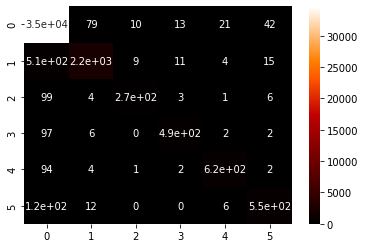

In [28]:
# валидация + MultiCollinearityEliminator порог коллинеарности 0.75 + oversampling + sampling_strategy + svd2
report = classification_report(Y_val, model.predict(X_val))
print(report)
print(f"Метрика: {0.2* recall_score(Y_val, model.predict(X_val), average='macro') + 0.8* precision_score(Y_val, model.predict(X_val), average='macro')}")

# посмотрим как ошибается модель
heat_map = np.zeros((6,6))
for (y, y_pred) in zip(Y_val.values.astype(int), model.predict(X_val).astype(int)):
    heat_map[y][y_pred] += 1
sns.heatmap(heat_map, annot=True, cmap="gist_heat")

In [29]:
# тренировочная выборка
report = classification_report(Y_train, model.predict(X_train))
print(report)
print(f"Метрика: {0.2* recall_score(Y_train, model.predict(X_train), average='macro') + 0.8* precision_score(Y_train, model.predict(X_train), average='macro')}")

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    139438
         1.0       1.00      1.00      1.00     10772
         2.0       1.00      1.00      1.00      1440
         3.0       1.00      1.00      1.00      2428
         4.0       1.00      1.00      1.00      2932
         5.0       1.00      1.00      1.00      2990

    accuracy                           1.00    160000
   macro avg       1.00      1.00      1.00    160000
weighted avg       1.00      1.00      1.00    160000

Метрика: 0.999695706833492


# Sample solution

In [30]:
# разделим выборки
XY_train = train[train['train'] == 1].drop('train', axis=1)
XY_test = train[train['train'] == 0].drop('train', axis=1)

X_train = XY_train.drop(['target'], 1)
Y_train = XY_train['target']

X_test = XY_test.drop(['target'], 1)

C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/2561632341.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = XY_train.drop(['target'], 1)
C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/2561632341.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = XY_test.drop(['target'], 1)


In [31]:
categorial_vars = ['program_id', 'student_id', 'communication_type', 'ABC', 'city', 'country', 'os', 'browser', \
                   'platform']

In [32]:
one_hot_target_encoder = OneHotTargetEncoder()

one_hot_target_encoder.fit(X_train[categorial_vars], Y_train)

X_train = pd.concat([X_train, one_hot_target_encoder.transform(X_train[categorial_vars])], axis=1)
X_test = pd.concat([X_test, one_hot_target_encoder.transform(X_test[categorial_vars])], axis=1)

X_train = X_train.drop(categorial_vars,1)
X_test = X_test.drop(categorial_vars,1)

C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/218761128.py:20: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  return X.drop(X_obj.columns,1)
C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/1999260008.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train = X_train.drop(categorial_vars,1)
C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/1999260008.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test = X_test.drop(categorial_vars,1)


In [33]:
X_train.drop(un_selected_features, 1, inplace=True)
X_test.drop(un_selected_features, 1, inplace=True)

C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/2153210587.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_train.drop(un_selected_features, 1, inplace=True)
C:\Users\vanya\AppData\Local\Temp/ipykernel_13820/2153210587.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  X_test.drop(un_selected_features, 1, inplace=True)


In [ ]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

In [34]:
model = XGBClassifier(max_depth=11, n_estimators=180, tree_method='gpu_hist', n_jobs=-1, reg_lambda = 1, reg_alpha=1)

In [35]:
model.fit(X_train, Y_train, sample_weight=my_sample_weights(Y_train))

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=0, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=180,
              n_jobs=-1, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=1, ...)

In [36]:
sample_solution = pd.read_csv('sample_solution.csv', index_col='id')

In [94]:
sample_solution['target'] = model.predict(X_test)

In [95]:
sample_solution.to_csv('sample_solution_sas.csv')

In [96]:
sample_solution_sas = pd.read_csv('sample_solution_sas.csv')

In [97]:
sample_solution_sas

,id,target
0,77551,0
1,227812,0
2,103035,0
3,260943,0
4,134611,0
...,...,...
84992,186427,0
84993,197918,0
84994,174961,0
84995,182226,0
